In [115]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
from go_learning_helpers import *
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import seaborn as sns

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [2]:
go_file = '../data/goData/kinase_go_processes.csv'
go_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(go_dir+go_file)

# filter out any empty kinases
go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

# generate binarized go_annotations
go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

# create a frequency chart for every label in the go_annotations 
# this allows us to screen out labels with only one occurence (to help reduce noise)
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1
texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

# generate binarized go_annotations for the intermediate, filtered go_annotations
filter_go_annotations = pd.Series(texts)
filter_go_annotations.index = go_annotations.index
filter_go_annotations.name = go_annotations.name

# filter out any empty filter_kinases
filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                   return_binarizer= True)
        
# create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

# create a tfidf series for the go_annotations
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# we have to parse gensim's sparse format back into pd.Series format
hold = []
rej = []
for i in range(len(corpus_tfidf)):
    if(len(corpus_tfidf[i]) > 1):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        rej += [go_annotations.index[i]]
    

tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
tfidf_go_annotations.name = go_annotations.name

# create a dictionary with our datasets
go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations }

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [3]:
cluster_dir = '../results/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [4]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [5]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}
    

In [6]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:np.mean(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    std_results[method] = {key:np.std(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    

In [7]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
    

spinglass | [0.26666667 0.2427959 ]
fastgreedy | [0.7037037  0.62389213]
eigen | [0.66666667 0.23223427]
labelprop | [0.97037037 0.73890975]
walktrap | [0.14814815 0.17103654]
louvain_super | [0.7037037  0.62557889]
louvain_sub | [0.39259259 0.38198415]
infomap | [0.33333333 0.23875031]
edge_between | [0.65185185 0.5053231 ]


In [8]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['ComplementNB']))
    

spinglass | [0.6        0.54311655]
fastgreedy | [0.63703704 0.55499324]
eigen | [0.53333333 0.18639912]
labelprop | [0.78518519 0.36378572]
walktrap | [0.42962963 0.39738883]
louvain_super | [0.7037037  0.63198127]
louvain_sub | [0.59259259 0.55333873]
infomap | [0.54074074 0.49355806]
edge_between | [0.67407407 0.50147602]


In [9]:
# old linear results
'''for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
    '''

"for method in method_list:\n    print(method+' | '+str(mean_results[method]['SVC']))\n    "

In [10]:
mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_table

,fast_greedy,spinglass,eigen,walktrap,label,louvain,small_louvain,infomap,edge_between
0,0.350078,0.338763,0.247766,0.272734,0.017304,0.368041,0.321034,0.281936,0.170605


In [11]:
cluster_descriptions = {}
mod_scores = {}

mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],3)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),2)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
louvain_super,8,59.1,46.9,151,0.368,0.70,0.0,0.63,0.0
fastgreedy,8,59.1,49.4,169,0.339,0.67,0.0,0.59,0.0
labelprop,15,31.5,110.5,445,0.273,0.88,0.0,0.55,0.0
edge_between,16,29.6,65.2,224,0.171,0.66,0.0,0.50,0.0
louvain_sub,36,13.1,18.1,88,0.321,0.49,0.0,0.47,0.0
spinglass,59,8.0,19.8,125,0.350,0.43,0.0,0.39,0.0
infomap,57,8.3,17.3,128,0.282,0.44,0.0,0.37,0.0
walktrap,162,2.9,7.8,79,0.017,0.29,0.0,0.28,0.0
eigen,11,43.0,94.7,330,0.248,0.60,0.0,0.21,0.0


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [12]:
tex_string = results_df.to_latex()
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &    Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
louvain\_super &             8 &       59.1 &        46.9 &            151 &  0.368 &      0.70 &             0.0 &      0.63 &             0.0 \\
fastgreedy    &             8 &       59.1 &        49.4 &            169 &  0.339 &      0.67 &             0.0 &      0.59 &             0.0 \\
labelprop     &            15 &       31.5 &       110.5 &            445 &  0.273 &      0.88 &             0.0 &      0.55 &             0.0 \\
edge\_between  &            16 &       29.6 &        65.2 &            224 &  0.171 &      0.66 &             0.0 &      0.50 &             0.0 \\
louvain\_sub   &            36 &       13.1 &        18.1 &             88 &  0.321 &      0.49 &             0.0 &      0.47 &             0.0 \\
spinglass     &            59 &        8.0 &        19.8 &            125 &  0.350 &  

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [13]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [14]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1                                           {8, 26, 7}
2                                   {4, 9, 10, 20, 21}
3                                             {11, 12}
4    {32, 1, 34, 36, 6, 13, 14, 15, 16, 17, 23, 24,...
5                           {35, 3, 5, 18, 25, 29, 31}
6                                                 {19}
7                                          {33, 2, 22}
8                                                 {30}
Name: cluster_sub, dtype: object

In [15]:
louvain_combined_dict.keys()

dict_keys(['go', 'freq', 'tfidf'])

In [16]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [17]:
validation_kwargs = {'n_run':5, 'metrics':['confusion'], 'parallel':None, 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            conf_intra_results_dict[sup_] = {clf_key:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [18]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

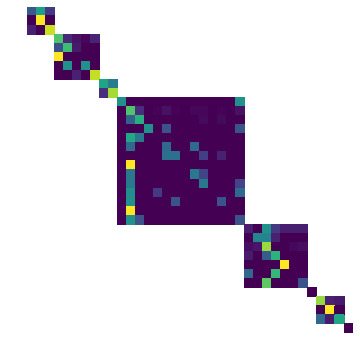

In [19]:
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)
intra_heatmap_matrix

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,6))
ax.axis('off')
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, ax=ax, square=True, cbar=False)

plt.show()

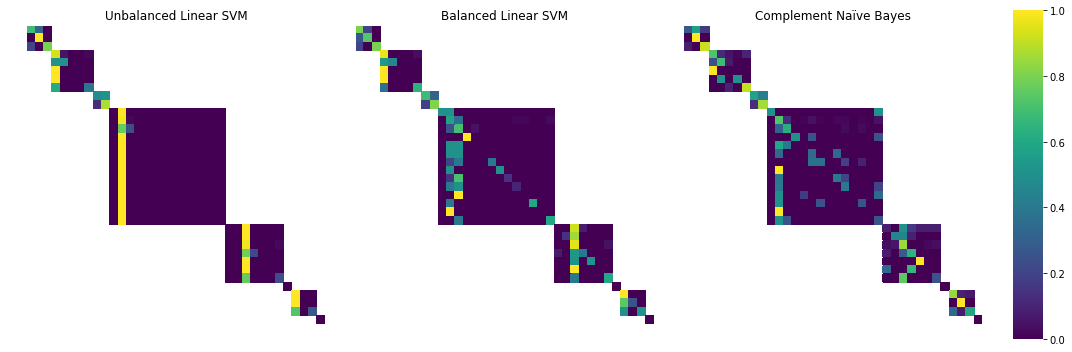

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('intracluster_learnability_comparison.png')

plt.show()

## Generate Learnability Characterizations

In [419]:
louv_X, __, louv_y, __ = get_tts(dat=louvain_super_dict['freq'],test_size=0)

In [420]:
louv_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_super_characterizers:
    clf.fit(louv_X, louv_y)

In [262]:
coeffs.shape

(7, 1361)

In [253]:
np.min(coeffs, axis=1)

array([-0.28844093, -0.2300957 , -0.267758  , -0.35411771, -0.44756603,
       -0.60421357, -0.22091056])

In [295]:
coeffs = np.zeros_like(local_coeffs)
for i in range(15):
    louv_X, louv_test_X, louv_y, louv_test_y = get_tts(dat=louvain_super_dict['tfidf'],test_size=0)
    for clf in louv_super_characterizers[:1]:
        clf.fit(louv_X, louv_y)
        
    local_coeffs = get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3)
    local_coeffs_row_min = np.min(local_coeffs, axis=1)
    local_coeffs_row_max = np.max(local_coeffs, axis=1)
    
    # normalize to 0-1 scale for each row
    for i in range(local_coeffs.shape[0]):
        local_coeffs[i,:] = (local_coeffs[i,:]+local_coeffs_row_min[i])/(local_coeffs_row_min[i]+local_coeffs_row_max[i])
    
    local_coeffs = 2*local_coeffs-1
    
    coeffs +=  local_coeffs

In [268]:
8*7/2

28.0

In [269]:
np.median(range(1,29))

14.5

In [271]:
coeffs = np.zeros_like(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3))
for i in range(15):
    num_classes=8
    louv_X, louv_test_X, louv_y, louv_test_y = get_tts(dat=louvain_super_dict['freq'],test_size=0)
    for clf in louv_super_characterizers[:1]:
        clf.fit(louv_X, louv_y)
        
    local_coeffs = copy(louv_super_characterizers[0].coef_)
    
    for col in range(local_coeffs.shape[1]):
        local_coeffs[:, col] = rankdata(local_coeffs[:, col])
    
    # 3 is the median for 7 classes
    local_coeffs -= 14.5
    
    # get positive and negative idx
    idx_locs_positive = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if 3 == y[0]]
    idx_locs_negative = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if 3 == y[1]]
    
    coeffs += np.vstack([local_coeffs[idx_locs_positive,:], -local_coeffs[idx_locs_negative,:]])

In [272]:
coeffs /= 15

In [214]:
p = louv_super_characterizers[0]


In [221]:
p.score(X=louv_X, y=louv_y)

0.9638297872340426

In [23]:
feat = freq_go_lab_binner.classes_.tolist()

In [25]:
5 in (7,5)

True

In [137]:
t = louv_super_characterizers[1]
t.feature_log_prob_.shape

(8, 1361)

In [142]:
len(t.class_count_)

8

In [189]:
np.argmax(np.exp(-t.feature_log_prob_[4,:]))

432

In [203]:
np.round(t.predict_proba(example.reshape(1,len(example3))), 2)

array([[0., 0., 0., 0., 1., 0., 0., 0.]])

In [184]:
np.exp(-t.feature_log_prob_[3,:])

array([0.00043586, 0.00058114, 0.00029057, ..., 0.00058114, 0.00043586,
       0.00217928])

In [211]:
normalizer = np.sum(np.exp(-t.feature_log_prob_), axis=0)
normalizer.shape

(1361,)

In [188]:
np.argmax(np.exp(-np.sum(t.feature_log_prob_[[i for i in range(8) if i != 4], :],axis=0)))

432

In [191]:
np.exp(-np.sum(t.feature_log_prob_[[i for i in range(8) if i != 3], :],axis=0))

array([5.31885840e-25, 2.98848340e-24, 1.06377168e-24, ...,
       5.04306574e-24, 7.09181120e-25, 6.55598546e-20])

In [140]:
np.matmul(np.exp(- t.feature_log_prob_), example)

array([0.06965237, 0.06687991, 0.06658676, 0.06872003, 0.05910868,
       0.06847498, 0.06809848, 0.06833494])

In [261]:
from scipy.stats import rankdata

In [176]:
def get_cnb_coeffs_for_cluster(cnb, cluster_num):
    num_classes = len(t.class_count_)
    probas = np.exp(- cnb.feature_log_prob_)
    
    idx_locs_positive = [i for i in range(num_classes) if i != cluster_num]
    idx_locs_negative = [cluster_num]
    
    print(cluster_num)
    print(idx_locs_positive)
    
    return cnb.feature_log_prob_[cluster_num, :]
    return np.vstack([probas[idx_locs_positive,:], -probas[idx_locs_negative,:]])

In [87]:
# new def
def get_svm_coeffs_for_cluster(svm, cluster_num):
    num_classes = len(svm.classes_)
    combos = list(it.combinations(range(num_classes),2))
    
    # append positive and negative occurrences 
    idx_locs_positive = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if cluster_num == y[0]]
    idx_locs_negative = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if cluster_num == y[1]]
    
    return np.vstack([svm.coef_[idx_locs_positive,:], -svm.coef_[idx_locs_negative,:]])

In [388]:
(coeffs-np.min(coeffs, axis=0))/np.max(coeffs, axis=0)
#coeffs

array([[0.32386887, 0.        , 0.08242118, ..., 1.08319603, 0.46790462,
        0.44223707],
       [0.        , 0.15601948, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48218475, 0.07891468, 0.13055479, ..., 1.23421153, 0.58985735,
        0.49790118],
       ...,
       [1.29713175, 0.73413775, 0.75652627, ..., 2.64462731, 1.29071429,
        1.22180589],
       [1.36127308, 1.10099054, 1.11889013, ..., 2.99114124, 1.73301401,
        1.64086157],
       [1.36165732, 0.79062094, 0.80839065, ..., 2.73460667, 1.35401973,
        1.28178446]])

In [157]:
def f_importances(coef, names, top=5, bot=None, plot=True, ax = None):
    ''' returns the most important top (positive) and bot (negative) features
    
    '''
    if bot is None:
        bot = top
    
    importances = coef
    
    # puts smallest first
    importances,names = zip(*sorted(zip(importances,names)))
    # smallest is still first
    most_negative_importances = importances[0:bot]
    most_negative_names = names[0:bot]
    
    most_positive_importances = importances[-top:]
    most_positive_names = names[-top:]
    
    
    if plot:
        if ax is None:
            plt.yticks(range(bot+top), most_negative_names+most_positive_names)
            plt.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            plt.barh(range(bot), most_negative_importances, align='center', color='blue')
            plt.show()
        else:
            ax.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            ax.barh(range(bot), most_negative_importances, align='center', color='blue')
            ax.set_yticks(range(bot+top))
            ax.set_yticklabels(most_negative_names+most_positive_names)
    else:
        return most_negative_names, most_negative_importances, most_positive_importances, most_positive_names
        

In [413]:
np.median(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 4)[:,1])

0.030235105812322232

In [414]:
np.median(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3)[:,1])

0.0

In [404]:
louv_super_characterizers[0].coef_[:,1]

array([-0.23176243, -0.07919247,  0.        , -0.14450017,  0.        ,
        0.        ,  0.        ,  0.29920608,  0.67069014,  0.57625263,
        0.04469709,  0.53977777,  0.06186974,  0.07474636, -0.06084642,
        0.01546432,  0.12825311,  0.01212187, -0.13009969,  0.        ,
        0.05350675,  0.        ,  0.10197608,  0.17745633,  0.03023511,
        0.        ,  0.        ,  0.        ])

In [433]:
louv_super_characterizers[0].coef_[:,0]

0.0

In [442]:
get_normalized_svm_coefficients_across_classes(louv_super_characterizers[0])[:,1]

array([-0.53368691, -0.53368691, -0.53368691, -0.53368691, -0.53368691,
       -0.53368691, -0.53368691, -1.        ])

(n_samples, n_classes * (n_classes - 1) / 2)

In [446]:
def get_normalized_svm_coefficients_across_classes(svm):
    num_classes = len(svm.classes_)
    coeffs_orig = svm.coef_
    median_score_list = [None]*num_classes

    # get the median score for every feature across all classes
    for c in range(num_classes):
        median_score_list[c] = np.mean(get_svm_coeffs_for_cluster(svm, c), axis=0)

    medians = np.vstack(median_score_list)
    min_medians = np.min(medians, axis=0)
    max_medians = np.max(medians, axis=0)
    
    np.place(max_medians, max_medians==0.0, 1.0)

    medians = (medians-min_medians)/(max_medians-min_medians)*2-1

    return medians

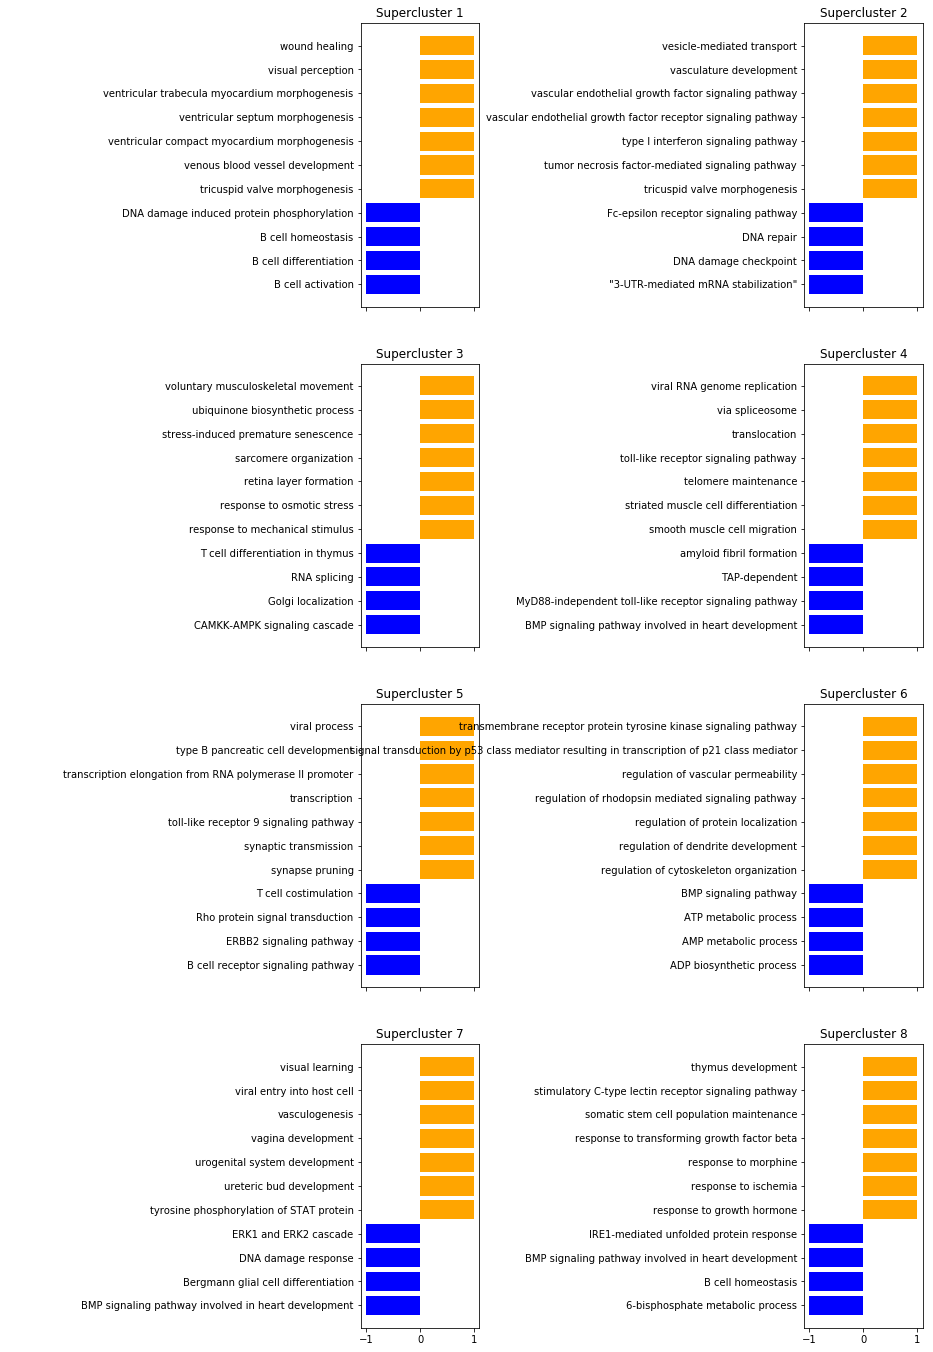

In [447]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,24), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=get_normalized_svm_coefficients_across_classes(louv_super_characterizers[0])[sup_-1,:], names=feat, ax=axes[idx // 2][idx % 2+1], top=7, bot=4)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


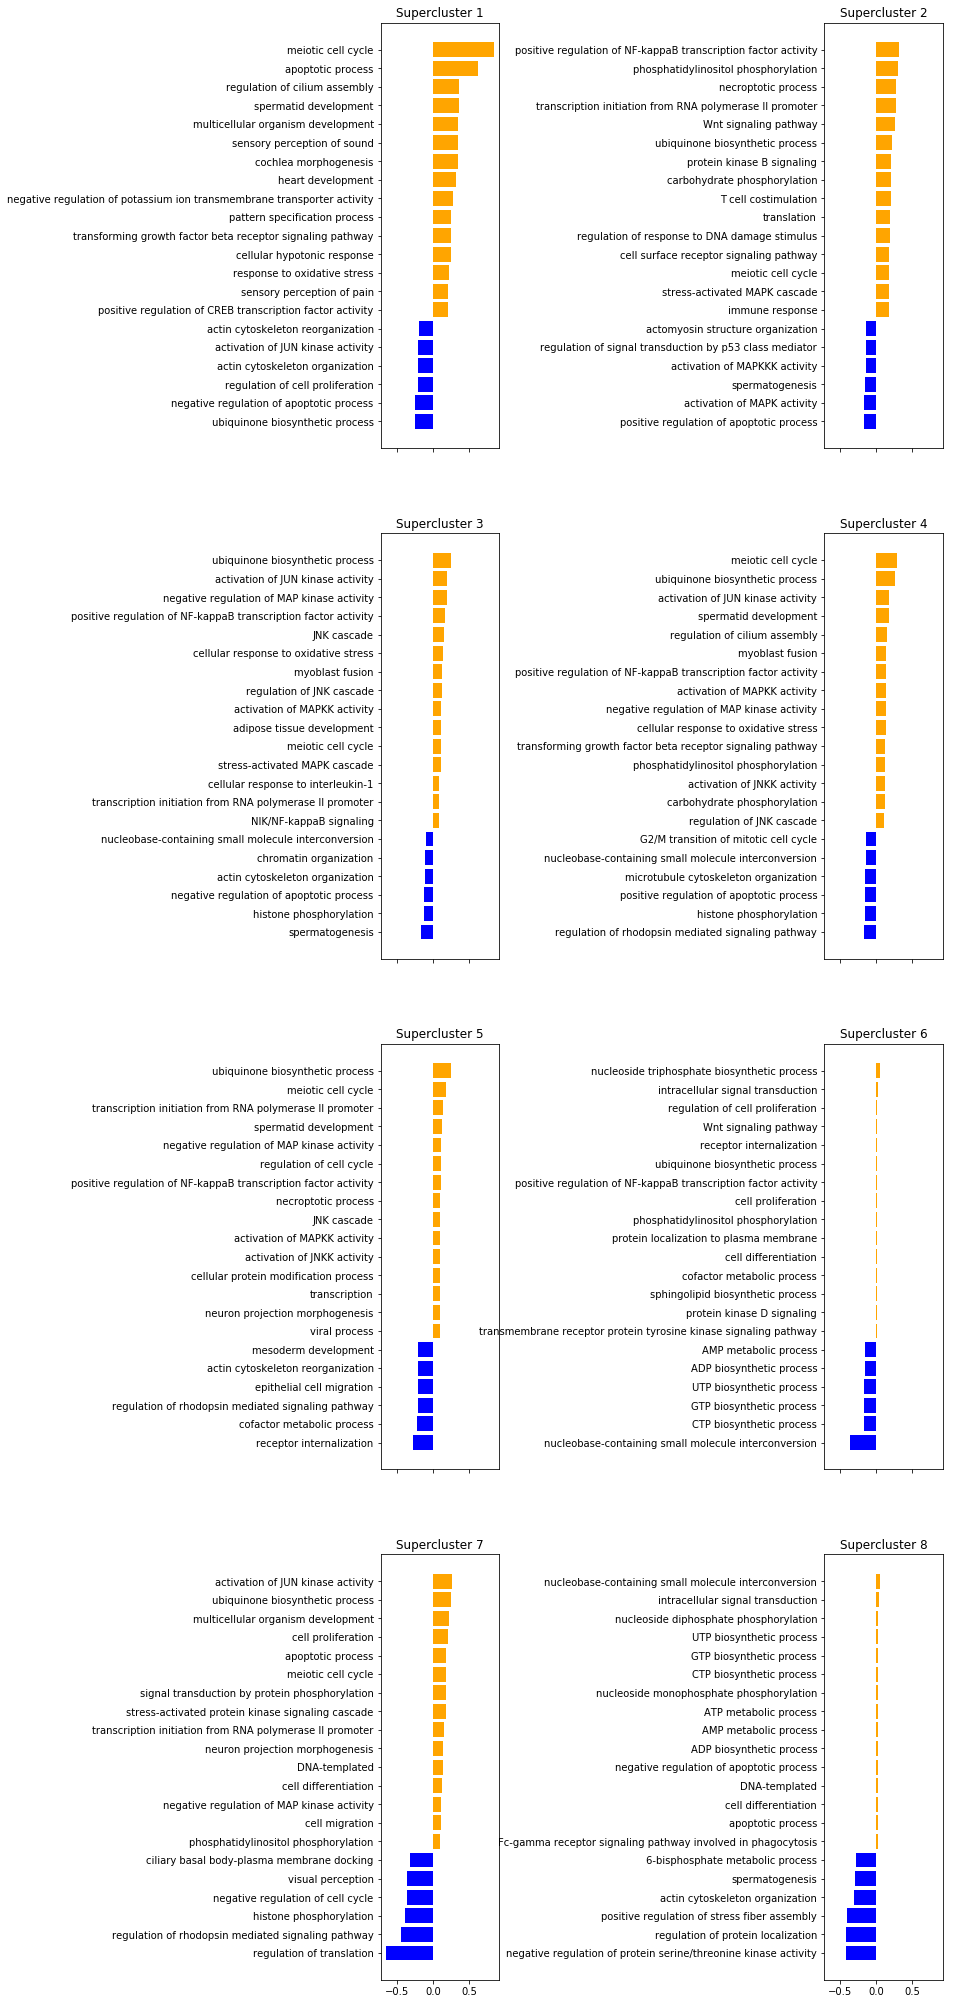

In [449]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,36), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 2][idx % 2+1], top=15, bot=6)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


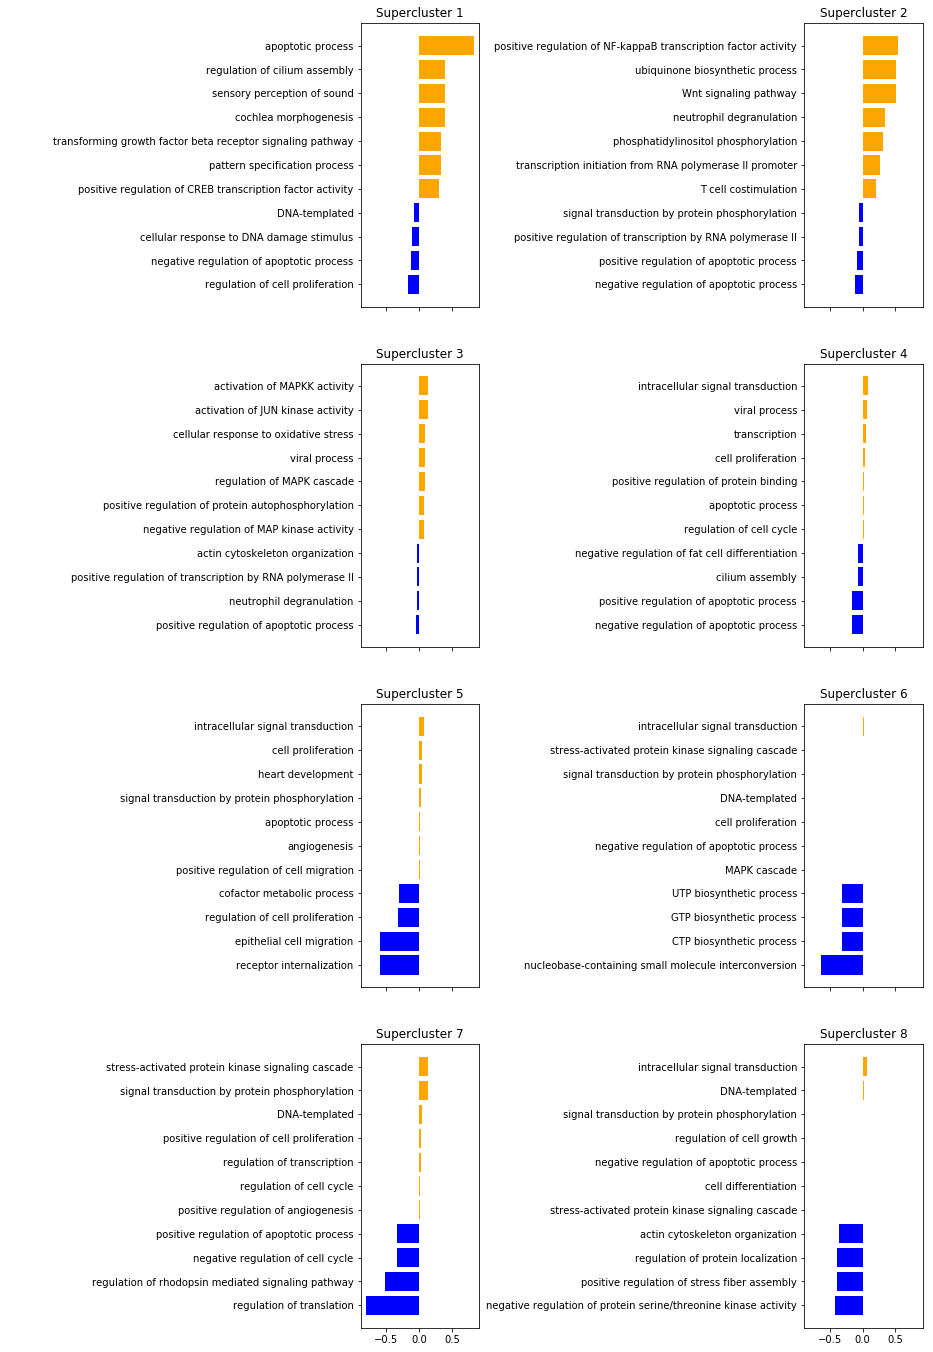

In [255]:
%matplotlib inline
fig, axes = plt.subplots(ncols=3, nrows=4, figsize= (16,24), sharex=True, gridspec_kw={'width_ratios':[1,20,20]})
plt.subplots_adjust(wspace=4.)
#plt.tight_layout()

for i in range(4):
    axes[i][0].axis('off')

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.median(get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 2][idx % 2+1], top=7, bot=4)
    axes[idx // 2][idx % 2+1].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


In [173]:
get_cnb_coeffs_for_cluster(louv_super_characterizers[1], 3)#.shape

3
[0, 1, 2, 4, 5, 6, 7]


array([[0.99956414, 0.99941886, 0.99970943, ..., 0.99941886, 0.99956414,
        0.99782072]])

In [174]:
np.sum(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3), axis=0).shape

(1361,)

In [267]:
coeffs

array([[ 0.5,  1.5,  0. , ...,  4. ,  0. ,  3. ],
       [ 0.5,  1.5, -1. , ...,  1.5,  3. ,  2. ],
       [ 4. ,  1.5,  1. , ...,  1.5,  4. ,  0. ],
       ...,
       [ 0.5,  1.5, -2. , ...,  1.5,  0. ,  0. ],
       [ 0.5,  1.5,  3. , ..., -2. ,  0. ,  4. ],
       [ 0.5, -2. ,  2. , ...,  1.5,  0. ,  0. ]])

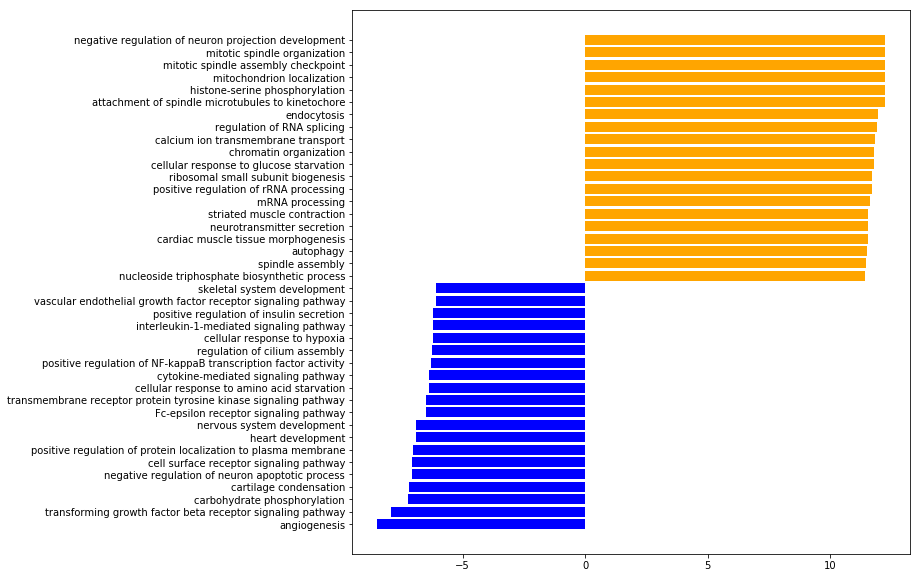

In [289]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
f_importances(coef=np.mean(coeffs, axis=0), names=feat, ax=axes, top=20, bot=20)

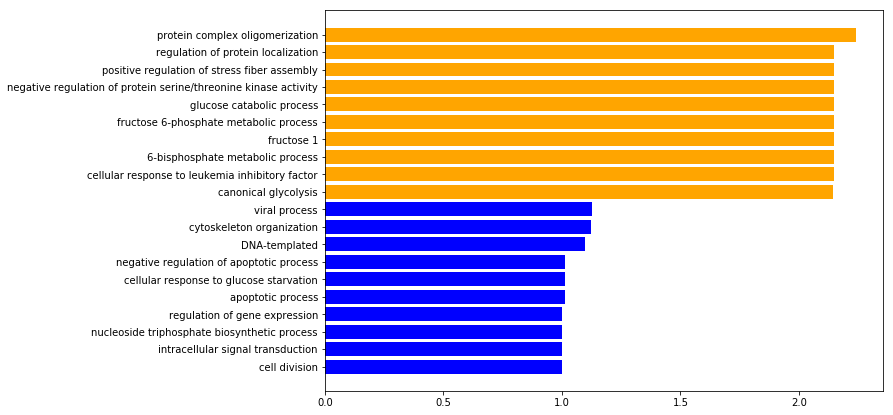

In [260]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
f_importances(coef=np.median(coeffs, axis=0), names=feat, ax=axes, top=10, bot=10)

In [248]:
np.sum(p.coef_, axis=1)

array([-10.00822369, -11.67406175,  -8.91520923, -15.15575076,
        -3.33047247, -12.17003046,  -3.17544923,  -0.23240547,
        14.28251292,  -0.08223929,  -1.48052184,   3.59388049,
        -1.33970198,   4.53693995,   0.96596973,  -3.33269868,
         4.73760922,  -3.43959858, -12.45563804,  -2.24588256,
        -6.69585604,  -2.1795796 ,  -1.13392604,   0.59684281,
        -0.86509628,   3.3335405 ,  -0.28921552,  -3.16775651])

In [244]:
(np.matmul(p.coef_, example) + p.intercept_)

array([-0.88566968, -0.22117895, -0.4270051 , -1.12531855,  0.99963497,
        0.70376926,  0.61304906,  1.70479816,  0.69014549, -1.22342742,
        1.01846883,  1.45870953,  0.6810721 ,  0.23042224, -1.82845998,
        0.9998096 ,  0.05917616,  0.66806208, -2.57374698,  1.03988418,
        0.57700347,  0.85687123,  1.05057163,  1.38602906,  1.00048842,
       -0.99999771, -0.21889611,  0.67649729])

In [240]:
p.decision_function(example.reshape(1,len(example)))

array([[ 2.98318033,  6.25595872,  4.93351965,  3.97087023,  7.5       ,
        -0.31052399,  1.87690508,  0.79008999]])

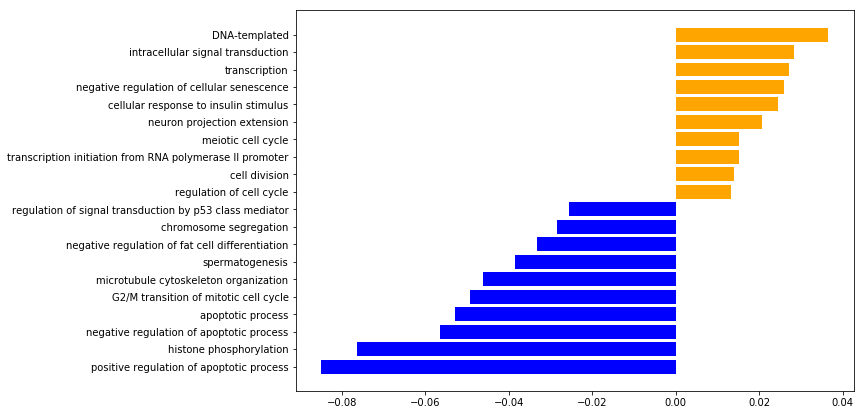

In [254]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
f_importances(coef=np.median(coeffs, axis=0), names=feat, ax=axes, top=10, bot=10)

3
[0, 1, 2, 4, 5, 6, 7]


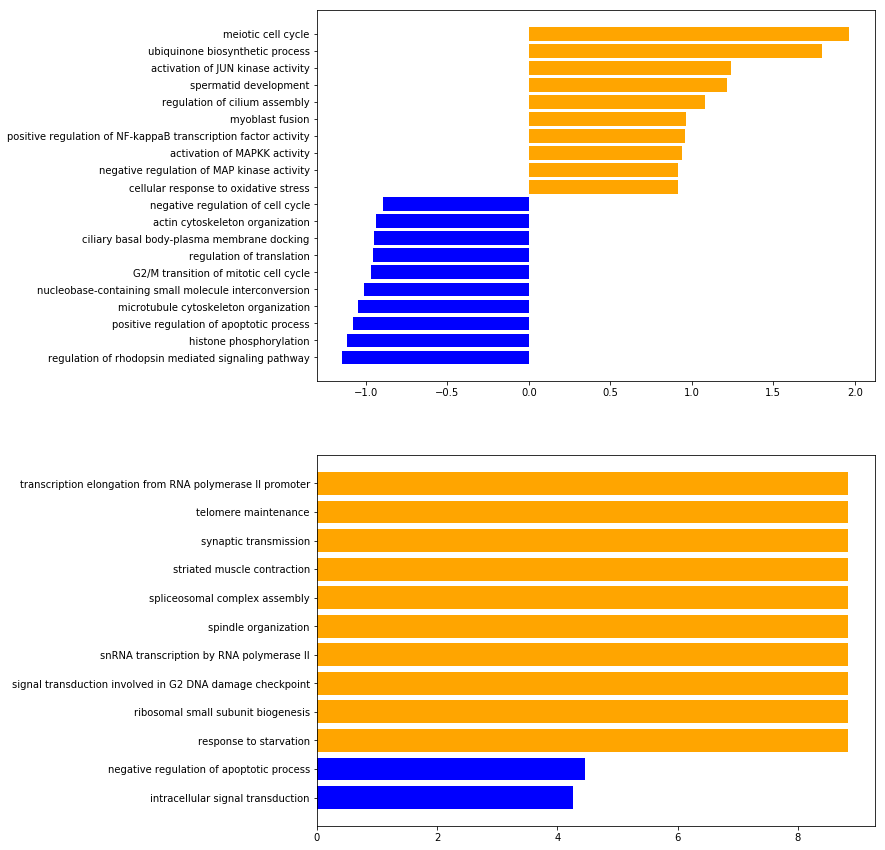

In [177]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15))
f_importances(coef=np.sum(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 3), axis=0), names=feat, ax=axes[0], top=10, bot=10)
f_importances(coef=get_cnb_coeffs_for_cluster(louv_super_characterizers[1], 3).reshape(1361,), names=feat, ax=axes[1], top=10, bot=2)

plt.show()

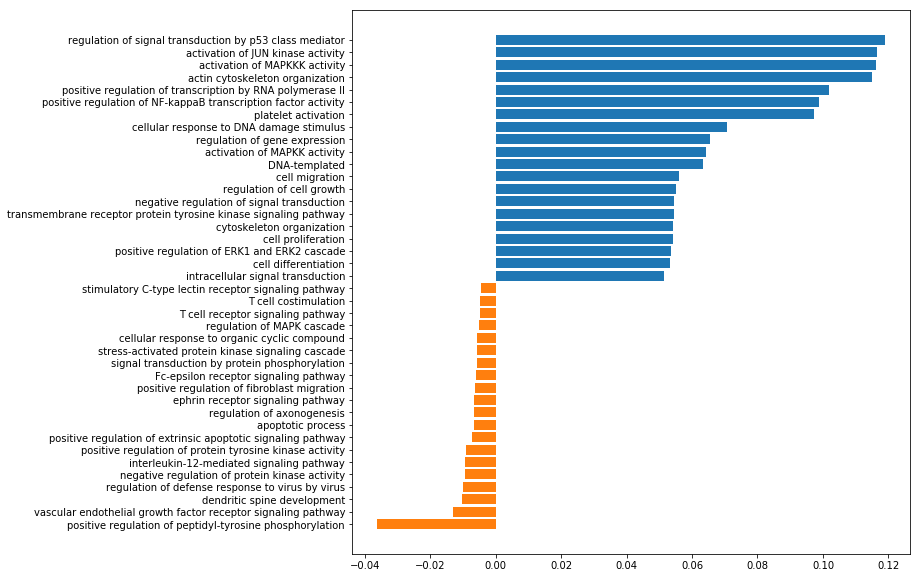

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 1), axis=0), names=feat)

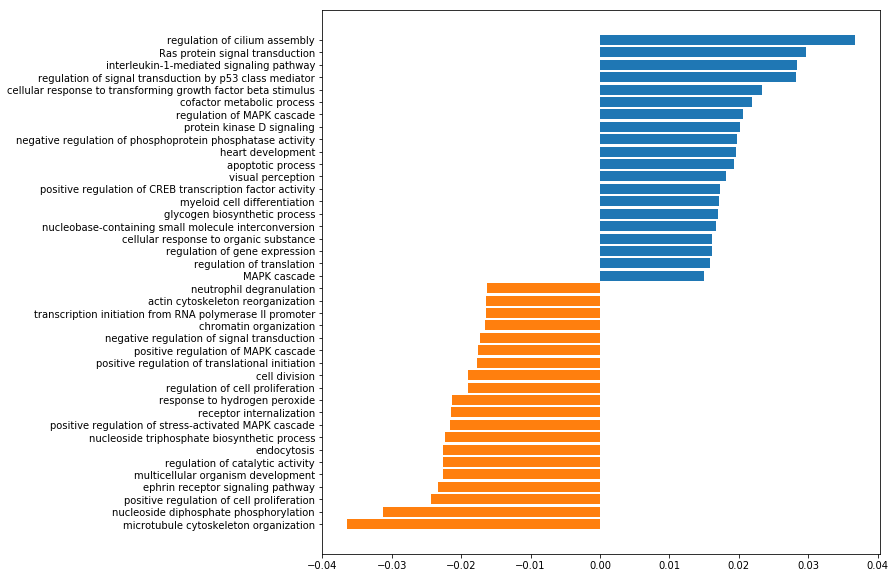

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 7), axis=0), names=feat)

In [92]:
set(filter(lambda x: 'apoptotic' in x, [term for doc in go_annotations for term in doc]))

{'B cell apoptotic process',
 'T cell apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic signaling pathway',
 'apoptotic cell clearance',
 'apoptotic mitochondrial changes',
 'apoptotic nuclear changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'endothelial cell apoptotic process',
 'extrinsic apoptotic signaling pathway',
 'extrinsic apoptotic signaling pathway in absence of ligand',
 'extrinsic apoptotic signaling pathway via death domain receptors',
 'fibroblast growth factor receptor apoptotic signaling pathway',
 'hepatocyte apoptotic process',
 'intrinsic apoptotic signaling pathway',
 'intrinsic apoptotic signaling pathway by p53 class mediator',
 'intrinsic apoptotic signaling pathway in response to DNA damage',
 'intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator',
 'intrinsic apoptotic signaling pathw

In [93]:
location = np.where(freq_go_lab_binner.transform(['apoptotic process']))[1][0]
print(location)

95


In [94]:
m_scores = []
for i in range(57):
    try:
        m = np.mean(get_svm_coeffs_for_cluster(svm, i), axis=0)[location]
    except:
        m = 0
        
    m_scores.append(m)

m_scores = np.array(list(filter(lambda x: np.isfinite(x), m_scores)))

In [95]:
low_value = np.percentile(np.array(m_scores), 5)
high_value = np.percentile(np.array(m_scores), 95)

print(low_value)
print(high_value)


-0.041134576199273964
0.02273108124140363


In [96]:
low_clusts = [x for x,y in enumerate(m_scores) if y < low_value]
low_clusts

[33, 40, 56]

In [97]:
high_clusts = [x for x,y in enumerate(m_scores) if y > high_value]
high_clusts

[1, 3, 50]

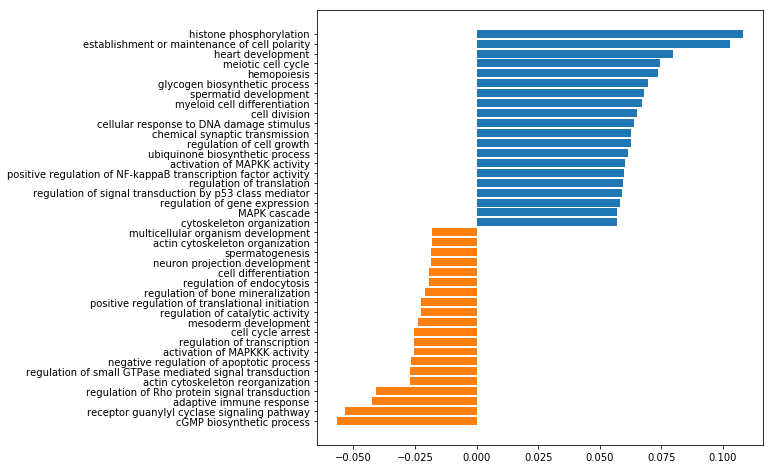

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 3), axis=0), names=feat)

### Understudied Test

In [331]:
hgnc = pd.read_csv('../data/hgnc_alias_list.txt', sep='\t')
#hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))


current_syn_list.head()

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


prev_symb_list.head()

hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196', 'MAPK3':'MAPK3'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


RAGE


In [375]:
hgnc_id_dict = hgnc.set_index('Approved symbol')['HGNC ID'].to_dict()

In [347]:
from scipy.stats import hypergeom
understudied = pd.read_csv('../data/dark_kinases.csv').symbol.tolist()

def test_understudied(clust, understudied, M):
    N = len(clust)
    
    rv = hypergeom(M, len(understudied), N)
    
    k = sum(map(lambda x: x in understudied, clust))
    
    return rv.pmf(k)

In [348]:
understudied_p_vals = []
louv_cluster_df = copy(louvain_combined_dict['go'].drop('GO Labels', axis=1))
louv_cluster_df.index = [hgnc_mapper[x] for x in louv_cluster_df.index]
louv_cluster_df.head()

,cluster_super,cluster_sub
PAK1,5,3
ERBB2,5,18
MST1R,5,18
YES1,5,18
TYRO3,5,18


In [362]:
louv_cluster_df.groupby('cluster_super')['understudied'].agg(sum)/louv_cluster_df.groupby('cluster_super')['understudied'].agg(len)

cluster_super
1    0.222222
2    0.120000
3    0.155172
4    0.410596
5    0.088235
6    0.000000
7    0.235294
8    0.250000
Name: understudied, dtype: float64

In [360]:
louv_cluster_df['understudied'] = pd.Series(louv_cluster_df.index.to_list()).apply(lambda x: x in understudied).to_list()

In [377]:
for i in louv_cluster_df[louv_cluster_df['cluster_super']==4].index.to_list():
    print(hgnc_id_dict[i])

HGNC:882
HGNC:9413
HGNC:8930
HGNC:8931
HGNC:6879
HGNC:9021
HGNC:3332
HGNC:12403
HGNC:12761
HGNC:2457
HGNC:795
HGNC:7199
HGNC:18994
HGNC:11389
HGNC:18282
HGNC:24615
HGNC:9377
HGNC:16059
HGNC:6514
HGNC:11812
HGNC:16384
HGNC:9077
HGNC:29650
HGNC:16627
HGNC:6896
HGNC:13205
HGNC:30172
HGNC:1149
HGNC:8982
HGNC:8974
HGNC:9376
HGNC:7749
HGNC:1925
HGNC:11841
HGNC:18591
HGNC:1778
HGNC:1470
HGNC:13386
HGNC:17994
HGNC:17995
HGNC:1464
HGNC:2459
HGNC:19035
HGNC:17209
HGNC:1780
HGNC:11842
HGNC:11405
HGNC:1771
HGNC:29558
HGNC:11390
HGNC:1773
HGNC:1777
HGNC:11406
HGNC:6515
HGNC:1745
HGNC:2069
HGNC:2071
HGNC:30598
HGNC:1774
HGNC:4113
HGNC:17848
HGNC:11403
HGNC:1148
HGNC:18593
HGNC:6878
HGNC:18174
HGNC:29043
HGNC:18608
HGNC:11404
HGNC:17270
HGNC:11394
HGNC:17880
HGNC:16061
HGNC:6721
HGNC:1722
HGNC:13575
HGNC:16243
HGNC:16870
HGNC:12718
HGNC:18996
HGNC:1497
HGNC:19006
HGNC:29165
HGNC:13480
HGNC:12558
HGNC:19034
HGNC:19036
HGNC:11305
HGNC:11306
HGNC:14311
HGNC:18618
HGNC:20461
HGNC:19699
HGNC:21680
HGNC:11

In [365]:
test_understudied(louv_cluster_df[louv_cluster_df['cluster_super']==7].index.to_list(), understudied, M=len(louv_cluster_df))

0.03106822833556578

In [370]:
understudied_p_vals

[0.07192211881041795,
 2.1609121849957114e-06,
 0.0005196563327387323,
 0.00742589581445108,
 5.0418416307850544e-11,
 0.12350687284379389,
 0.03106822833556578,
 0.3919589989307886]

In [368]:
sorted(louv_cluster_df.cluster_super.unique())

[1, 2, 3, 4, 5, 6, 7, 8]

In [367]:
understudied_p_vals = []
for i in sorted(louv_cluster_df.cluster_super.unique()):
    understudied_p_vals.append(test_understudied(louv_cluster_df[louv_cluster_df['cluster_super']==i].index.to_list(), understudied, M=len(louv_cluster_df)))

In [364]:
sum(louv_cluster_df['cluster_super']==7)

51

In [369]:
understudied_clusts = []

for loc, p_val in enumerate(understudied_p_vals):
    if(p_val < 0.05):
        understudied_clusts += [loc+1]
        
print(understudied_clusts)

[2, 3, 4, 5, 7]


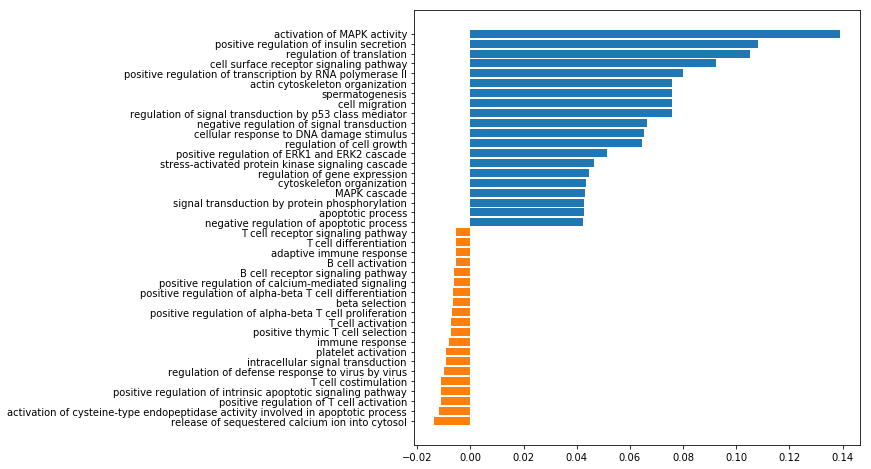

In [109]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 5), axis=0), names=feat)

In [111]:
spinglass_clusters[spinglass_clusters['cluster']==5]

,cluster,GO Labels,names
names,,,
KSYK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",KSYK
BTK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",BTK
ZAP70,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",ZAP70
LCK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",LCK


In [116]:
spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)

Below is the fast_greedy membership of each c_spinglass cluster

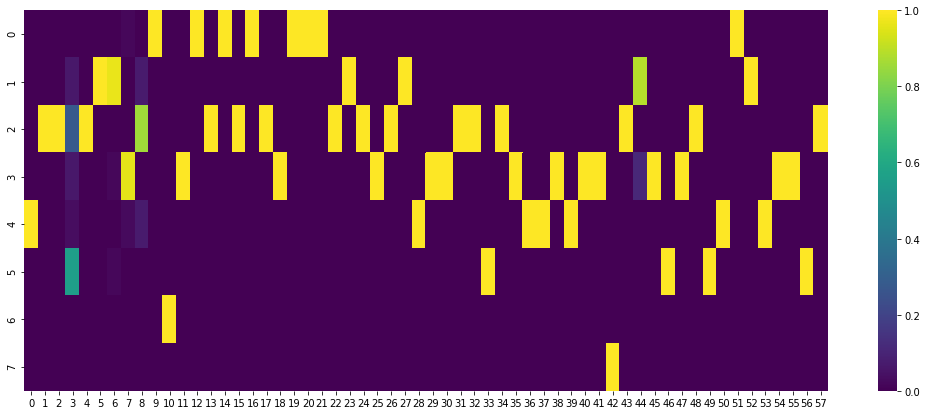

In [117]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(18,7))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Below is the c_spinglass membership of each fast_greedy cluster

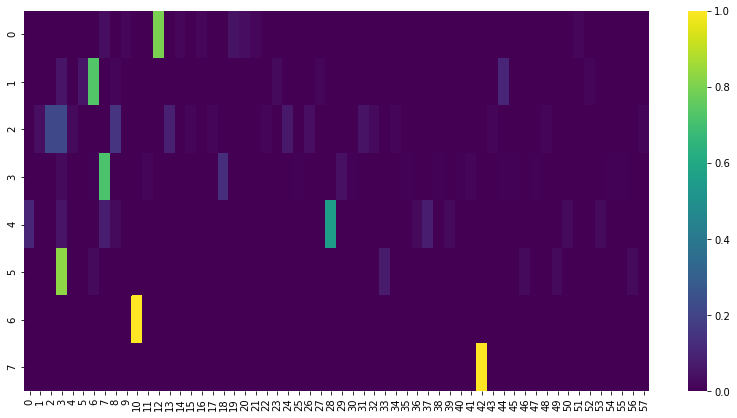

In [118]:
cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)

fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Rand correlation matrix

In [153]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

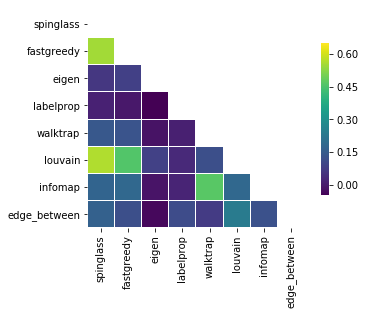

In [177]:
from sklearn.metrics import adjusted_rand_score as rand

rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=0.65, cbar_kws={"shrink": .7}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list)